In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the MBTI dataset
df = pd.read_csv("/kaggle/input/predict-people-personality-types/data.csv")

In [5]:
# Show the first few rows and dataset info
print(df.head())
print("\nDataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMBTI types distribution:\n", df['Personality'].value_counts())

    Age  Gender  Education  Introversion Score  Sensing Score  Thinking Score  \
0  21.0  Female          1             5.89208       2.144395         7.32363   
1  24.0  Female          1             2.48366       3.206188         8.06876   
2  26.0  Female          1             7.02910       6.469302         4.16472   
3  30.0    Male          0             5.46525       4.179244         2.82487   
4  31.0  Female          0             3.59804       6.189259         5.31347   

   Judging Score Interest Personality  
0       5.462224     Arts        ENTP  
1       3.765012  Unknown        INTP  
2       5.454442   Others        ESFP  
3       5.080477   Sports        ENFJ  
4       3.677984   Others        ISFP  

Dataset shape: (43744, 9)

Columns: ['Age', 'Gender', 'Education', 'Introversion Score', 'Sensing Score', 'Thinking Score', 'Judging Score', 'Interest', 'Personality']

MBTI types distribution:
 Personality
ENTP    2734
INTP    2734
ESFP    2734
ENFJ    2734
ISFP    2734


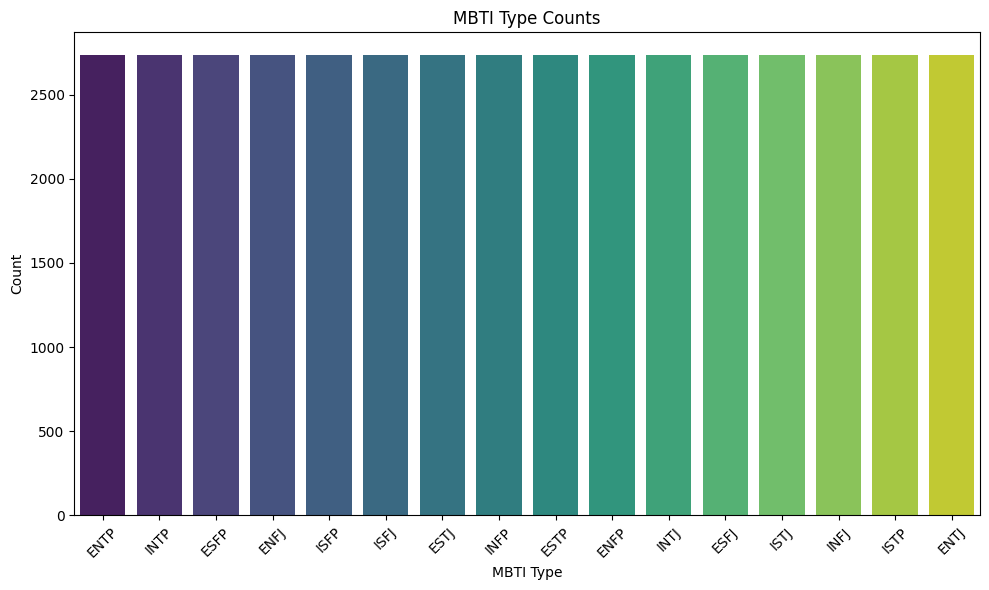

In [6]:
# Plot MBTI types distribution
plt.figure(figsize=(10,6))
sns.countplot(x='Personality', data=df, order=df['Personality'].value_counts().index, palette="viridis")
plt.title('MBTI Type Counts')
plt.xlabel('MBTI Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder

# Copy dataset for processing
data = df.copy()

# Encode categorical features
le_gender = LabelEncoder()
data['Gender'] = le_gender.fit_transform(data['Gender'])  # Female=0, Male=1

le_edu = LabelEncoder()
data['Education'] = le_edu.fit_transform(data['Education'])

le_interest = LabelEncoder()
data['Interest'] = le_interest.fit_transform(data['Interest'])

le_personality = LabelEncoder()
data['Personality'] = le_personality.fit_transform(data['Personality'])

# Show mappings for sanity check
print("Gender classes:", le_gender.classes_)
print("Education classes:", le_edu.classes_)
print("Interest classes:", le_interest.classes_)
print("Personality classes:", le_personality.classes_)
print("\nProcessed data head:\n", data.head())

Gender classes: ['Female' 'Male']
Education classes: [0 1]
Interest classes: ['Arts' 'Others' 'Sports' 'Technology' 'Unknown']
Personality classes: ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']

Processed data head:
     Age  Gender  Education  Introversion Score  Sensing Score  Thinking Score  \
0  21.0       0          1             5.89208       2.144395         7.32363   
1  24.0       0          1             2.48366       3.206188         8.06876   
2  26.0       0          1             7.02910       6.469302         4.16472   
3  30.0       1          0             5.46525       4.179244         2.82487   
4  31.0       0          0             3.59804       6.189259         5.31347   

   Judging Score  Interest  Personality  
0       5.462224         0            3  
1       3.765012         4           11  
2       5.454442         1            5  
3       5.080477         2            0  
4       3.677984 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = data.drop('Personality', axis=1)
y = data['Personality']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (34995, 8)
Test shape: (8749, 8)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

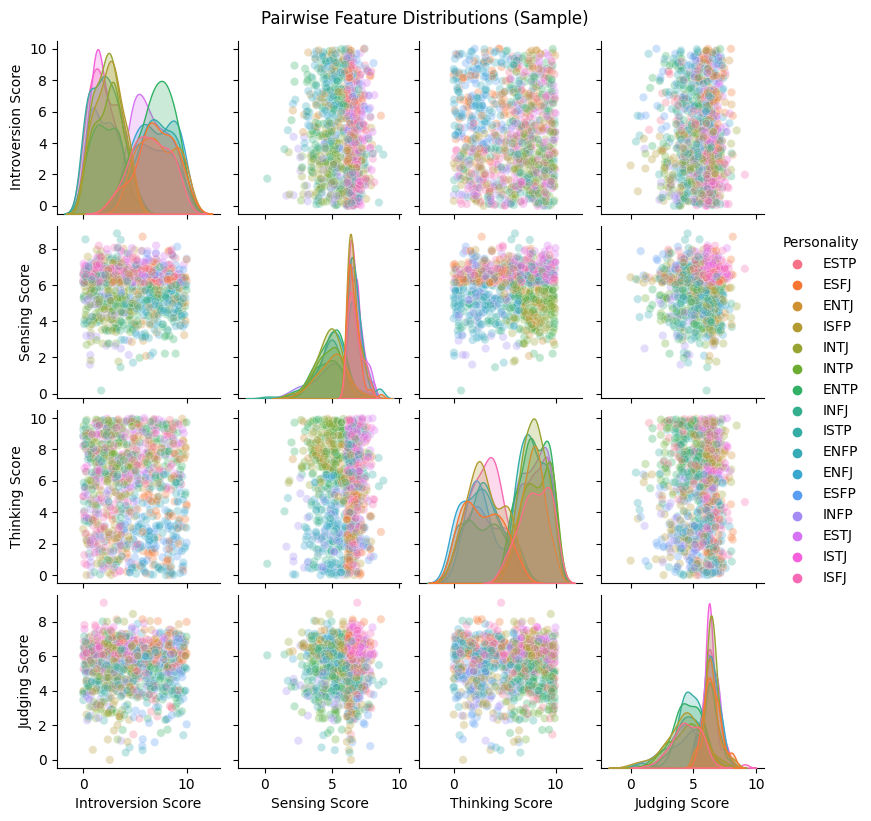

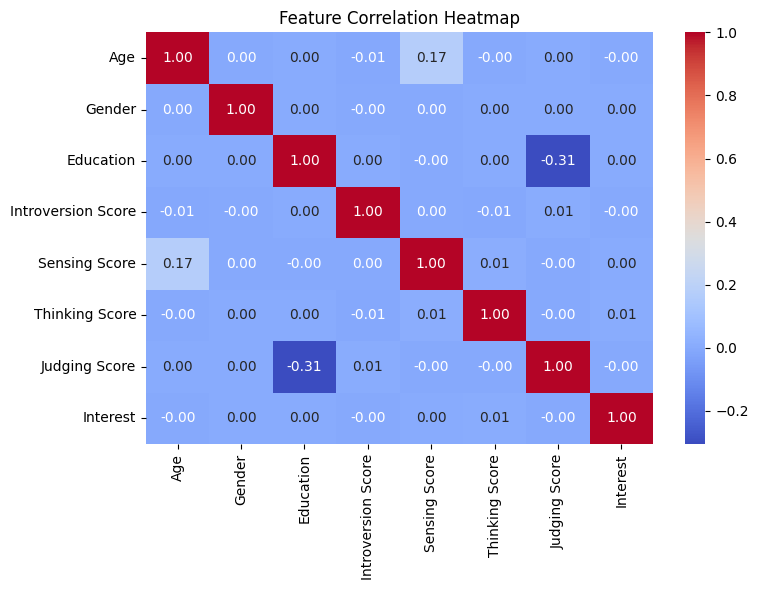

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# For visualization, add back 'Personality' as decoded label
viz_data = X_train.copy()
viz_data['Personality'] = le_personality.inverse_transform(y_train)

# Pairplot: see class separability
sns.pairplot(viz_data.iloc[:1000], hue='Personality', vars=[
    'Introversion Score', 'Sensing Score', 'Thinking Score', 'Judging Score'
], diag_kind='kde', plot_kws={'alpha':0.3}, height=2)
plt.suptitle('Pairwise Feature Distributions (Sample)', y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

print("Training Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Calculate accuracies
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"Train Accuracy: {lr_train_acc:.4f}")
print(f"Test Accuracy: {lr_test_acc:.4f}")

# Store results for comparison later
results = {
    'Model': ['Logistic Regression'],
    'Train_Accuracy': [lr_train_acc],
    'Test_Accuracy': [lr_test_acc],
    'Training_Time': [end_time - start_time]
}

print("\nClassification Report:")
print(classification_report(y_test, lr_test_pred, target_names=le_personality.classes_))

Training Logistic Regression...
Training time: 1.69 seconds
Train Accuracy: 0.7683
Test Accuracy: 0.7688

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.81      0.72      0.76       546
        ENFP       0.89      0.66      0.76       546
        ENTJ       0.76      0.76      0.76       547
        ENTP       0.83      0.69      0.76       547
        ESFJ       0.73      0.83      0.77       547
        ESFP       0.82      0.77      0.79       546
        ESTJ       0.72      0.87      0.79       547
        ESTP       0.79      0.79      0.79       547
        INFJ       0.78      0.73      0.75       547
        INFP       0.85      0.67      0.75       547
        INTJ       0.76      0.78      0.77       547
        INTP       0.80      0.72      0.76       547
        ISFJ       0.70      0.86      0.77       547
        ISFP       0.76      0.77      0.76       547
        ISTJ       0.68      0.90      0.77       547
      

#### This shows best fit (76.83% and 76.88%)

### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

print("Training Decision Tree...")
start_time = time.time()

dt_model = DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_split=10)
dt_model.fit(X_train, y_train)

# Predictions
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)

# Calculate accuracies
dt_train_acc = accuracy_score(y_train, dt_train_pred)
dt_test_acc = accuracy_score(y_test, dt_test_pred)

end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"Train Accuracy: {dt_train_acc:.4f}")
print(f"Test Accuracy: {dt_test_acc:.4f}")

# Add to results
results['Model'].append('Decision Tree')
results['Train_Accuracy'].append(dt_train_acc)
results['Test_Accuracy'].append(dt_test_acc)
results['Training_Time'].append(end_time - start_time)

print("\nClassification Report:")
print(classification_report(y_test, dt_test_pred, target_names=le_personality.classes_))

# Feature importance
feature_names = X_train.columns
importances = dt_model.feature_importances_

print("\nFeature Importances:")
for i, importance in enumerate(importances):
    print(f"{feature_names[i]}: {importance:.4f}")

Training Decision Tree...
Training time: 0.24 seconds
Train Accuracy: 0.9532
Test Accuracy: 0.8713

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.87      0.86      0.87       546
        ENFP       0.87      0.85      0.86       546
        ENTJ       0.86      0.90      0.88       547
        ENTP       0.89      0.88      0.88       547
        ESFJ       0.86      0.88      0.87       547
        ESFP       0.86      0.85      0.85       546
        ESTJ       0.90      0.88      0.89       547
        ESTP       0.86      0.86      0.86       547
        INFJ       0.88      0.85      0.87       547
        INFP       0.85      0.86      0.86       547
        INTJ       0.90      0.87      0.88       547
        INTP       0.88      0.85      0.86       547
        ISFJ       0.87      0.88      0.88       547
        ISFP       0.84      0.89      0.87       547
        ISTJ       0.89      0.92      0.91       547
        ISTP

#### This shows overfitting (95.32% and 87.13%)

### RandomForest

Training Random Forest...
Training time: 6.02 seconds
Train Accuracy: 0.9527
Test Accuracy: 0.8987

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.91      0.88      0.89       546
        ENFP       0.93      0.84      0.88       546
        ENTJ       0.92      0.90      0.91       547
        ENTP       0.93      0.86      0.89       547
        ESFJ       0.88      0.91      0.90       547
        ESFP       0.91      0.89      0.90       546
        ESTJ       0.91      0.92      0.91       547
        ESTP       0.89      0.91      0.90       547
        INFJ       0.92      0.88      0.90       547
        INFP       0.88      0.88      0.88       547
        INTJ       0.93      0.89      0.91       547
        INTP       0.90      0.88      0.89       547
        ISFJ       0.87      0.93      0.90       547
        ISFP       0.84      0.95      0.89       547
        ISTJ       0.90      0.95      0.92       547
        ISTP

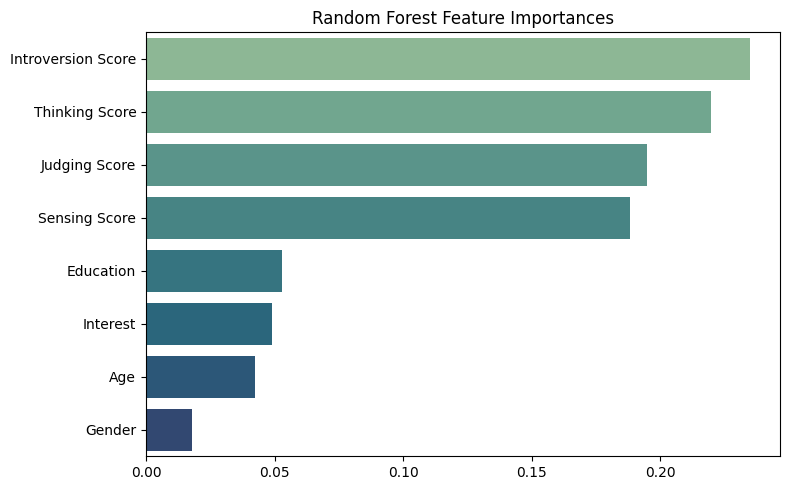

In [12]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_split=10)
rf_model.fit(X_train, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Calculate accuracies
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"Train Accuracy: {rf_train_acc:.4f}")
print(f"Test Accuracy: {rf_test_acc:.4f}")

# Add to results
results['Model'].append('Random Forest')
results['Train_Accuracy'].append(rf_train_acc)
results['Test_Accuracy'].append(rf_test_acc)
results['Training_Time'].append(end_time - start_time)

print("\nClassification Report:")
print(classification_report(y_test, rf_test_pred, target_names=le_personality.classes_))

# Random Forest Feature Importance Plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(8,5))
plt.title("Random Forest Feature Importances")
sns.barplot(x=importances[indices], y=feature_names[indices], palette="crest")
plt.tight_layout()
plt.show()

#### This shows overfitting (95.27% and 89.87%)

### XGBoost

Training XGBoost...
Training time: 4.45 seconds
Train Accuracy: 0.9884
Test Accuracy: 0.8918

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.92      0.87      0.89       546
        ENFP       0.91      0.85      0.88       546
        ENTJ       0.90      0.89      0.89       547
        ENTP       0.93      0.86      0.90       547
        ESFJ       0.88      0.90      0.89       547
        ESFP       0.90      0.90      0.90       546
        ESTJ       0.90      0.91      0.91       547
        ESTP       0.88      0.91      0.89       547
        INFJ       0.91      0.88      0.89       547
        INFP       0.87      0.88      0.88       547
        INTJ       0.92      0.87      0.90       547
        INTP       0.88      0.87      0.88       547
        ISFJ       0.87      0.92      0.89       547
        ISFP       0.85      0.92      0.88       547
        ISTJ       0.90      0.94      0.92       547
        ISTP      

<Figure size 800x500 with 0 Axes>

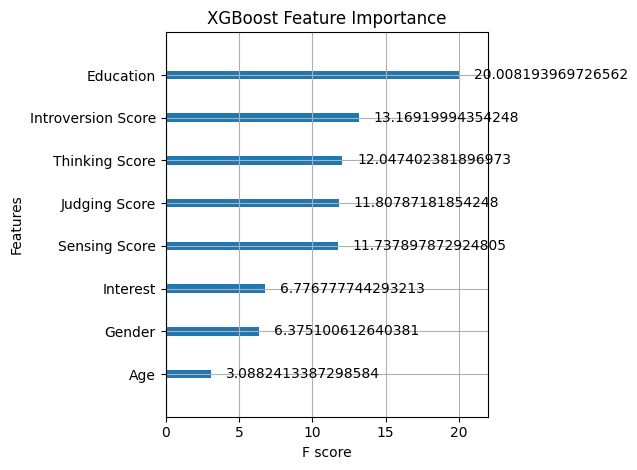

In [13]:
import xgboost as xgb

print("Training XGBoost...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Calculate accuracies
xgb_train_acc = accuracy_score(y_train, xgb_train_pred)
xgb_test_acc = accuracy_score(y_test, xgb_test_pred)

end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"Train Accuracy: {xgb_train_acc:.4f}")
print(f"Test Accuracy: {xgb_test_acc:.4f}")

# Add to results
results['Model'].append('XGBoost')
results['Train_Accuracy'].append(xgb_train_acc)
results['Test_Accuracy'].append(xgb_test_acc)
results['Training_Time'].append(end_time - start_time)

print("\nClassification Report:")
print(classification_report(y_test, xgb_test_pred, target_names=le_personality.classes_))

# XGBoost Feature Importance Plot
plt.figure(figsize=(8,5))
xgb.plot_importance(xgb_model, max_num_features=8, importance_type='gain', title='XGBoost Feature Importance')
plt.tight_layout()
plt.show()

#### This shows overfitting (98.84% and 89.18%)

### Neural Networks - Sequential

2025-10-05 19:06:53.771602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759691214.123057      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759691214.223930      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training Deep Sequential Model with Dropout...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759691232.908519      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759691232.910308      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/60


I0000 00:00:1759691237.088325     113 service.cc:148] XLA service 0x7d752c042ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759691237.089616     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759691237.089637     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759691237.476389     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759691239.939446     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


121/121 - 9s - 72ms/step - accuracy: 0.4681 - loss: 1.6486 - val_accuracy: 0.7640 - val_loss: 0.6711
Epoch 2/60
121/121 - 0s - 3ms/step - accuracy: 0.7090 - loss: 0.8198 - val_accuracy: 0.7983 - val_loss: 0.5495
Epoch 3/60
121/121 - 0s - 3ms/step - accuracy: 0.7428 - loss: 0.7033 - val_accuracy: 0.8093 - val_loss: 0.5019
Epoch 4/60
121/121 - 0s - 3ms/step - accuracy: 0.7676 - loss: 0.6397 - val_accuracy: 0.8188 - val_loss: 0.4625
Epoch 5/60
121/121 - 0s - 3ms/step - accuracy: 0.7807 - loss: 0.5931 - val_accuracy: 0.8336 - val_loss: 0.4349
Epoch 6/60
121/121 - 0s - 3ms/step - accuracy: 0.7975 - loss: 0.5525 - val_accuracy: 0.8400 - val_loss: 0.4125
Epoch 7/60
121/121 - 0s - 3ms/step - accuracy: 0.8088 - loss: 0.5155 - val_accuracy: 0.8455 - val_loss: 0.3971
Epoch 8/60
121/121 - 0s - 3ms/step - accuracy: 0.8177 - loss: 0.4918 - val_accuracy: 0.8548 - val_loss: 0.3806
Epoch 9/60
121/121 - 0s - 3ms/step - accuracy: 0.8218 - loss: 0.4681 - val_accuracy: 0.8588 - val_loss: 0.3714
Epoch 10/60

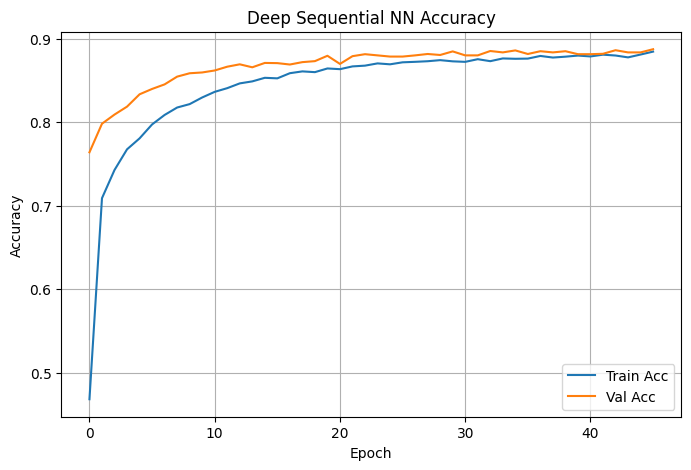

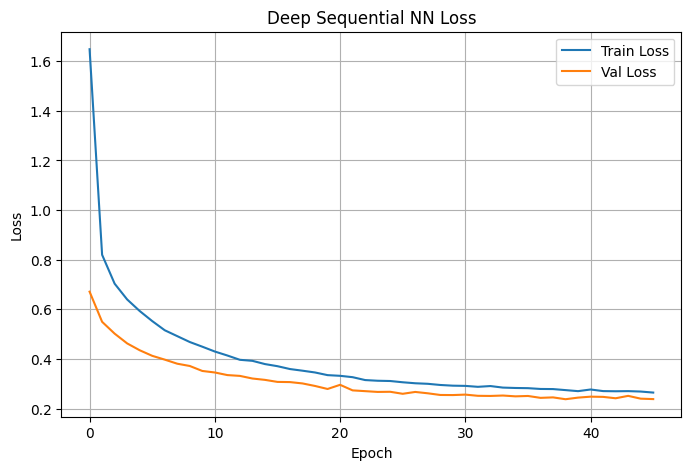

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Preparing categorical targets for Keras (one-hot encoding)
y_train_oh = to_categorical(y_train, num_classes=16)
y_test_oh = to_categorical(y_test, num_classes=16)

print("Training Deep Sequential Model with Dropout...")
start_time = time.time()

deep_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.35),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.15),
    Dense(32, activation='relu'),
    Dense(16, activation='softmax')
])

deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

history = deep_model.fit(
    X_train_scaled, y_train_oh,
    epochs=60,
    batch_size=256,
    validation_split=0.12,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)],
    verbose=2
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Evaluate
train_loss, train_acc = deep_model.evaluate(X_train_scaled, y_train_oh, verbose=0)
test_loss, test_acc = deep_model.evaluate(X_test_scaled, y_test_oh, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Add to results
results['Model'].append('Deep Sequential NN')
results['Train_Accuracy'].append(train_acc)
results['Test_Accuracy'].append(test_acc)
results['Training_Time'].append(end_time - start_time)

# Plot training history
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Deep Sequential NN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Deep Sequential NN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### This shows best fit (89.68% and 89.06%)

### Neural Networks - MLPClassifier

Training Neural Network...
Training time: 32.04 seconds
Train Accuracy: 0.9066
Test Accuracy: 0.8883
Number of iterations: 77

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.87      0.90      0.88       546
        ENFP       0.93      0.83      0.88       546
        ENTJ       0.90      0.89      0.90       547
        ENTP       0.94      0.82      0.88       547
        ESFJ       0.87      0.90      0.88       547
        ESFP       0.90      0.90      0.90       546
        ESTJ       0.88      0.89      0.89       547
        ESTP       0.86      0.92      0.89       547
        INFJ       0.91      0.86      0.89       547
        INFP       0.88      0.89      0.88       547
        INTJ       0.94      0.88      0.90       547
        INTP       0.87      0.89      0.88       547
        ISFJ       0.89      0.89      0.89       547
        ISFP       0.87      0.92      0.89       547
        ISTJ       0.86      0.93      

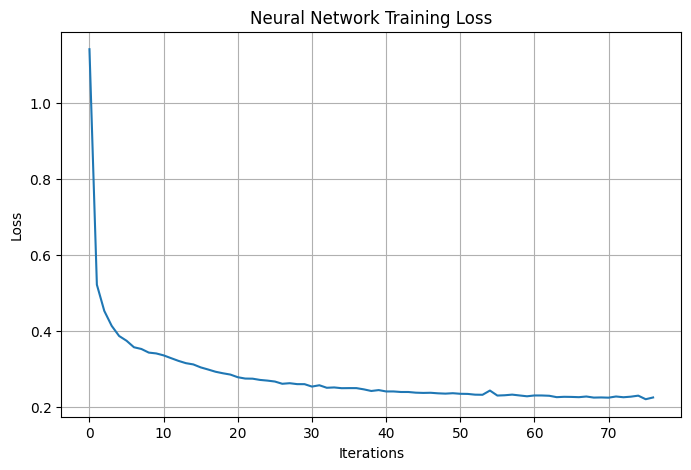

In [15]:
from sklearn.neural_network import MLPClassifier

print("Training Neural Network...")
start_time = time.time()

nn_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=128,
    learning_rate='adaptive',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

nn_model.fit(X_train_scaled, y_train)

# Predictions
nn_train_pred = nn_model.predict(X_train_scaled)
nn_test_pred = nn_model.predict(X_test_scaled)

# Calculate accuracies
nn_train_acc = accuracy_score(y_train, nn_train_pred)
nn_test_acc = accuracy_score(y_test, nn_test_pred)

end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"Train Accuracy: {nn_train_acc:.4f}")
print(f"Test Accuracy: {nn_test_acc:.4f}")
print(f"Number of iterations: {nn_model.n_iter_}")

# Add to results
results['Model'].append('Neural Network')
results['Train_Accuracy'].append(nn_train_acc)
results['Test_Accuracy'].append(nn_test_acc)
results['Training_Time'].append(end_time - start_time)

print("\nClassification Report:")
print(classification_report(y_test, nn_test_pred, target_names=le_personality.classes_))

# Plot training loss curve
plt.figure(figsize=(8,5))
plt.plot(nn_model.loss_curve_)
plt.title('Neural Network Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#### This shows good fit (90.66% and 88.83%)

## Compare all models

Model Comparison with Overfitting Gap:

                 Model  Train_Accuracy  Test_Accuracy  Training_Time  \
0  Logistic Regression          0.7683         0.7688         1.6947   
1        Decision Tree          0.9532         0.8713         0.2383   
2        Random Forest          0.9527         0.8987         6.0172   
3              XGBoost          0.9884         0.8918         4.4505   
4   Deep Sequential NN          0.8968         0.8906        28.9917   
5       Neural Network          0.9066         0.8883        32.0372   

   Accuracy_Diff  
0         0.0005  
1         0.0819  
2         0.0539  
3         0.0966  
4         0.0062  
5         0.0183  


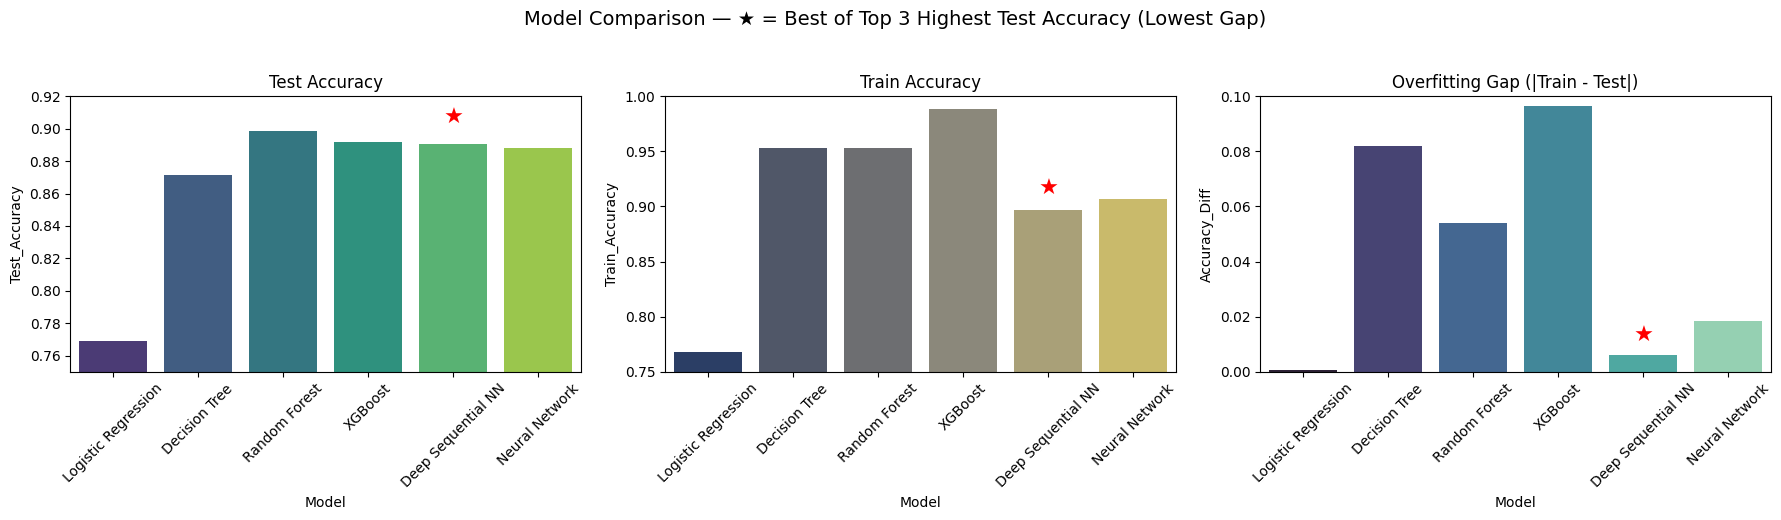


Best model among Top 3 highest test accuracy, with lowest overfitting gap: Deep Sequential NN
Test Accuracy: 0.8906, Overfitting Gap: 0.0062


In [17]:
# Create and update results DataFrame
results_df = pd.DataFrame(results)
results_df['Accuracy_Diff'] = (results_df['Train_Accuracy'] - results_df['Test_Accuracy']).abs()

print("Model Comparison with Overfitting Gap:\n")
print(results_df.round(4))

# --- Top 3 by Test Accuracy ---
top3 = results_df.nlargest(3, 'Test_Accuracy').copy()

# --- Among Top 3, Pick Best by Smallest Accuracy Gap ---
min_gap_idx = top3['Accuracy_Diff'].idxmin()
best_model_top3 = results_df.loc[min_gap_idx, 'Model']
best_test_acc = results_df.loc[min_gap_idx, 'Test_Accuracy']
best_diff = results_df.loc[min_gap_idx, 'Accuracy_Diff']

# Plot Test Accuracy, Train Accuracy, and Accuracy Gap
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Test Accuracy
bars1 = sns.barplot(data=results_df, x='Model', y='Test_Accuracy', ax=ax1, palette="viridis")
ax1.set_title("Test Accuracy")
ax1.set_ylim(0.75, 0.92)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Train Accuracy
bars2 = sns.barplot(data=results_df, x='Model', y='Train_Accuracy', ax=ax2, palette="cividis")
ax2.set_title("Train Accuracy")
ax2.set_ylim(0.75, 1.00)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Overfitting Gap
bars3 = sns.barplot(data=results_df, x='Model', y='Accuracy_Diff', ax=ax3, palette="mako")
ax3.set_title("Overfitting Gap (|Train - Test|)")
ax3.set_ylim(0, 0.1)
ax3.tick_params(axis='x', rotation=45)

# Highlight the best model with a star
for i, model in enumerate(results_df['Model']):
    if model == best_model_top3:
        ax1.text(i, results_df.loc[i, 'Test_Accuracy'] + 0.01, '★',
                ha='center', va='bottom', fontsize=16, color='red')
        ax2.text(i, results_df.loc[i, 'Train_Accuracy'] + 0.01, '★',
                ha='center', va='bottom', fontsize=16, color='red')
        ax3.text(i, results_df.loc[i, 'Accuracy_Diff'] + 0.003, '★',
                ha='center', va='bottom', fontsize=16, color='red')

plt.suptitle("Model Comparison — ★ = Best of Top 3 Highest Test Accuracy (Lowest Gap)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

# Print best model details
print(f"\nBest model among Top 3 highest test accuracy, with lowest overfitting gap: {best_model_top3}")
print(f"Test Accuracy: {best_test_acc:.4f}, Overfitting Gap: {best_diff:.4f}")

## Best Model is Deep Sequential Neural Network

In [19]:
mbti_descriptions = {
    'ENTJ': 'The Commander: Strategic leaders, motivated to organize change',
    'INTJ': 'The Mastermind: Analytical problem-solvers, eager to improve systems and processes',
    'ENTP': 'The Visionary: Inspired innovators, seeking new solutions to challenging problems',
    'INTP': 'The Architect: Philosophical innovators, fascinated by logical analysis',
    'ENFJ': 'The Teacher: Idealist organizers, driven to do what is best for humanity',
    'INFJ': 'The Counselor: Creative nurturers, driven by a strong sense of personal integrity',
    'ENFP': 'The Champion: People-centered creators, motivated by possibilities and potential',
    'INFP': 'The Healer: Imaginative idealists, guided by their own values and beliefs',
    'ESTJ': 'The Supervisor: Hardworking traditionalists, taking charge to get things done',
    'ISTJ': 'The Inspector: Responsible organizers, driven to create order out of chaos',
    'ESFJ': 'The Provider: Conscientious helpers, dedicated to their duties to others',
    'ISFJ': 'The Protector: Industrious caretakers, loyal to traditions and institutions',
    'ESTP': 'The Dynamo: Energetic thrillseekers, ready to push boundaries and dive into action',
    'ISTP': 'The Craftsperson: Observant troubleshooters, solving practical problems',
    'ESFP': 'The Entertainer: Vivacious entertainers, loving life and charming those around them',
    'ISFP': 'The Composer: Gentle caretakers, enjoying the moment with low-key enthusiasm'
}

def predict_mbti_userinput():
    print("Enter feature values for MBTI prediction (ensure correct case for categorical features):")
    
    age = float(input("Age (e.g., 25): ").strip())
    gender = input(f"Gender {list(le_gender.classes_)}: ").strip()
    education = input(f"Education {list(le_edu.classes_)}: ").strip()
    interest = input(f"Interest {list(le_interest.classes_)}: ").strip()
    introversion = float(input("Introversion Score (0–10, e.g., 5.2): ").strip())
    sensing = float(input("Sensing Score (0–10, e.g., 4.3): ").strip())
    thinking = float(input("Thinking Score (0–10, e.g., 6.1): ").strip())
    judging = float(input("Judging Score (0–10, e.g., 7.0): ").strip())
    
    try:
        gender_enc = le_gender.transform([gender])[0]
    except:
        print(f"Invalid gender. Use one of {list(le_gender.classes_)}.")
        return
    try:
        education_enc = le_edu.transform([education])[0]
    except:
        print(f"Invalid education. Use one of {list(le_edu.classes_)}.")
        return
    try:
        interest_enc = le_interest.transform([interest])[0]
    except:
        print(f"Invalid interest. Use one of {list(le_interest.classes_)}.")
        return

    user_features = np.array([[age, gender_enc, education_enc,
                               introversion, sensing,
                               thinking, judging, interest_enc]])
    user_features_scaled = scaler.transform(user_features)
    
    pred_proba = deep_model.predict(user_features_scaled)
    pred_class = np.argmax(pred_proba)
    mbti_pred = le_personality.inverse_transform([pred_class])[0]
    description = mbti_descriptions.get(mbti_pred, "Description not found")

    print(f"\nPredicted MBTI Type: {mbti_pred}")
    print(f"Description: {description}\n")
    print("Class Probabilities:")
    for cls, prob in zip(le_personality.classes_, pred_proba[0]):
        print(f"  {cls}: {prob:.3f}")

predict_mbti_userinput()

Enter feature values for MBTI prediction (ensure correct case for categorical features):


Age (e.g., 25):  21
Gender ['Female', 'Male']:  Male
Education [0, 1]:  1
Interest ['Arts', 'Others', 'Sports', 'Technology', 'Unknown']:  Technology
Introversion Score (0–10, e.g., 5.2):  7
Sensing Score (0–10, e.g., 4.3):  5
Thinking Score (0–10, e.g., 6.1):  6
Judging Score (0–10, e.g., 7.0):  5.6


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Predicted MBTI Type: ENFP
Description: The Champion: People-centered creators, motivated by possibilities and potential

Class Probabilities:
  ENFJ: 0.000
  ENFP: 0.998
  ENTJ: 0.000
  ENTP: 0.001
  ESFJ: 0.000
  ESFP: 0.000
  ESTJ: 0.000
  ESTP: 0.000
  INFJ: 0.000
  INFP: 0.001
  INTJ: 0.000
  INTP: 0.000
  ISFJ: 0.000
  ISFP: 0.000
  ISTJ: 0.000
  ISTP: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Save the model

In [20]:
import joblib

# Save scaler and all encoders
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le_gender, 'le_gender.joblib')
joblib.dump(le_edu, 'le_edu.joblib')
joblib.dump(le_interest, 'le_interest.joblib')
joblib.dump(le_personality, 'le_personality.joblib')

print("Preprocessing objects saved with joblib.")

# Save the deep Keras model
deep_model.save('deep_mbti_model.h5')

print("Deep Sequential NN saved as deep_mbti_model.h5")

Preprocessing objects saved with joblib.
Deep Sequential NN saved as deep_mbti_model.h5
